# Assignment 1, Deep Learning Fundamentals

# Import libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score


# Import and proprocess of the dataset

In [2]:
# Import dataset
X, y = load_svmlight_file("/Users/fuchuenli/Desktop/Year 1/Trimester 3/COMP SCI 7318/Week 2/Assignment 1/diabete.txt")

Number of healthy entity: 268
Number of diabetic patients: 500


<BarContainer object of 2 artists>

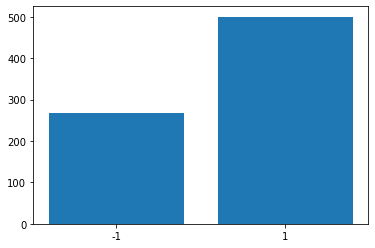

In [3]:
# Check number of -1 and 1 distribution in the dataset
y_1 = y.tolist().count(1)
y_m1 = y.tolist().count(-1)
print(f"Number of healthy entity: {y_m1}")
print(f"Number of diabetic patients: {y_1}")
plt.bar(["-1",'1'], [y_m1,y_1])

In [4]:
# Combine in one dataset for further processing
dataset = hstack((y.reshape(768,1), X)).toarray()

In [5]:
# A peak of the whole dataset
dataset

array([[-1.        , -0.294118  ,  0.487437  , ...,  0.00149028,
        -0.53117   , -0.0333333 ],
       [ 1.        , -0.882353  , -0.145729  , ..., -0.207153  ,
        -0.766866  , -0.666667  ],
       [-1.        , -0.0588235 ,  0.839196  , ..., -0.305514  ,
        -0.492741  , -0.633333  ],
       ...,
       [ 1.        , -0.411765  ,  0.21608   , ..., -0.219076  ,
        -0.857387  , -0.7       ],
       [-1.        , -0.882353  ,  0.266332  , ..., -0.102832  ,
        -0.768574  , -0.133333  ],
       [ 1.        , -0.882353  , -0.0653266 , ..., -0.0938897 ,
        -0.797609  , -0.933333  ]])

In [6]:
# Split the whole dataset into training, validation and testing set in a ratio of 70:15:15
training_set_whole, testing_set = train_test_split(dataset, train_size=0.85, test_size=0.15,
                                             stratify=dataset[:,0], random_state=0)
training_set, validation_set = train_test_split(training_set_whole, train_size=0.82, test_size=0.18,
                                               stratify=training_set_whole[:,0], random_state=0)

In [7]:
# Split into X(features) and y(label)
X_train = training_set[:,1:]
y_train = training_set[:,0:1]
X_valid = validation_set[:,1:]
y_valid = validation_set[:,0:1]
X_test = testing_set[:,1:]
y_test = testing_set[:,0:1]

In [8]:
# Check the shape of the datasets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_valid: {X_valid.shape}")
print(f"Shape of y_valid: {y_valid.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (534, 8)
Shape of y_train: (534, 1)
Shape of X_valid: (118, 8)
Shape of y_valid: (118, 1)
Shape of X_test: (116, 8)
Shape of y_test: (116, 1)


# Perceptron building

In [9]:
# A perceptron class to perform training, plotting etc functions
class Perceptron:
    def __init__(self):
        # Dataset
        self._X = None
        self._y = None
        self._X_valid = None
        self._y_valid = None
        # Learning rate
        self._learning_rate = 0
        # Weight
        np.random.seed(0)
        self._weight = None
        self._best_weight = None
        # Early stopping
        self._early_stopping_cycle = 0
        self._stop_counter = 0
        self._max_iteration = 0
        self._iteration = 1
        # Cost function
        self._gradient = None
        self._loss = 0
        self._accuracy = 0
        self._best_loss = np.inf
        self._best_accuracy = 0
        self._loss_list = []
        self._accuracy_list = []
        self._valid_accuracy = 0
        self._valid_accuarcy_list = []
        # Batch Size
        self._batch_size = 0
        self._execution_time = 0
        
    # Train the preceptron
    def train(self, X=None, y=None, max_iteration=1000, learning_rate=0.1, 
              early_stopping_cycle=10, verbose=0, batch_size = None):
        # Instantiate variables from parameters
        self._X = np.vstack((np.ones((1,X.shape[0])), X.T)).T
        self._y = y
        self._max_iteration = max_iteration
        self._learning_rate = learning_rate
        self._early_stopping_cycle = early_stopping_cycle
        self._weight = np.random.uniform(low=-100, high=100, size=self._X[0,:].shape)
        if batch_size == None:
                self._batch_size = self._y.shape[0]
        else:
            self._batch_size = batch_size
        # Training loop
        start_time = time.time()
        while self._iteration < self._max_iteration :
            # Cost function calculation
            self._gradient = np.zeros(self._X[0,:].shape[0])
            self._loss = 0
            row_count = 0
            while True:
                try:
                    for row in range(self._batch_size):
                        if self._y[row_count+row]*(self._X[row_count+row].dot(self._weight)) <= 0:
                            self._gradient += self._y[row_count+row]*self._X[row_count+row]
                            self._loss += -self._y[row_count+row]*(self._X[row_count+row].dot(self._weight))
                    row_count += row +1
                except:
                    break
                    
                self._weight = self._weight + self._learning_rate*self._gradient
             
            # Early Stopping
            self._accuracy = 0
            in_loop_predication = []
            for i in range(self._X.shape[0]):
                if self._X[i].dot(self._weight) <= 0:
                    in_loop_predication.append(-1)
                else:
                    in_loop_predication.append(1)
            self._accuracy = accuracy_score(y_pred= in_loop_predication, y_true=self._y)
            
            if self._accuracy > self._best_accuracy:
                self._best_accuracy = self._accuracy
                self._best_weight = self._weight
                self._stop_counter = 0

            else:
                self._stop_counter += 1
                
            if  self._stop_counter > self._early_stopping_cycle:
                break
            
            # Mismatch and accuracy list for plotting graph
            self._loss_list.append(self._loss)
            self._accuracy_list.append(self._accuracy)
            
            # Showing training details
            if verbose == 1:
                print(f"iteration: {self._iteration}")
                print(f"loss: {self._gradient}")
                print(f"weight: {self._weight}")
                print("")
                
            # Count for finishing an iteration
            self._iteration += 1
        
        # Final error and weight 
        if verbose == 1:
            print(f"Best weight: {self._best_weight}")
            print("")
        self._execution_time = time.time() - start_time
        print(f"execution time: {self._execution_time}")
    # Plot the learning curve
    def learning_curve(self, save=False):
        fig, ax = plt.subplots(1,1, figsize=[6,6])
        ax.scatter([i for i in range(len(self._accuracy_list))], self._accuracy_list, marker=".", label="Accuracy")
        ax.scatter([i for i in range(len(self._loss_list))], [i/max(self._loss_list)for i in self._loss_list], marker=".", label="Loss")
        ax.legend()
        ax.set_title(f"Learning curve of the perceptron: batch_size={self._batch_size} learning_rate={self._learning_rate}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy/Loss")
        
        if save == True:
            fig.savefig(f"/Users/fuchuenli/Desktop/Year 1/Trimester 3/COMP SCI 7318/Week 2/Assignment 1/batch_size_{self._batch_size}_learning_rate={self._learning_rate}.png")
    
    # Predict new data
    def predict(self, df):
        prediction = []
        df = np.vstack((np.ones((1,df.shape[0])), df.T)).T
        for i in range(df.shape[0]):
            if df[i].dot(self._best_weight) < 0:
                prediction.append(-1)
            else:
                prediction.append(1)
        return prediction

# Artificial Linearly Separable Dataset

In [10]:
# Create artificial data
np.random.seed(0)
artificial_data_x = np.concatenate([np.random.normal(0,2,500), np.random.normal(10,2,500)], axis=0)
artificial_data_y = np.concatenate([np.random.normal(0,2,500), np.random.normal(10,2,500)], axis=0)
artificial_data_label = np.concatenate([np.full((1,500), -1)[0], np.ones((1,500))[0]], axis=0)

In [11]:
# Add bias to artificial data
artificial_dataset = np.vstack([np.vstack([artificial_data_x.T, artificial_data_y.T]), artificial_data_label.T]).T
artificial_dataset

array([[ 3.52810469,  1.11192536, -1.        ],
       [ 0.80031442,  1.78494777, -1.        ],
       [ 1.95747597, -0.84462965, -1.        ],
       ...,
       [10.1883846 , 10.31686769,  1.        ],
       [ 7.70477811,  7.71619716,  1.        ],
       [ 9.28377185,  7.37805926,  1.        ]])

Text(0.5, 1.0, 'Artificial data scatter plot')

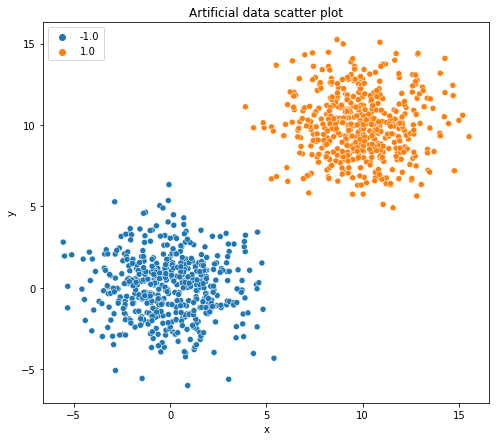

In [12]:
# Scatter plot of the artificial data
fig, ax = plt.subplots(1,1,figsize=[8,7])
sns.scatterplot(data=artificial_dataset, x=artificial_dataset[:,0], y=artificial_dataset[:,1], hue=artificial_dataset[:,2], palette="tab10", ax=ax)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Artificial data scatter plot")
#fig.savefig("/Users/fuchuenli/Desktop/Year 1/Trimester 3/COMP SCI 7318/Week 2/Assignment 1/artificial data plot")

In [13]:
# Split dataset in artificial data
art_training_set, art_testing_set = train_test_split(artificial_dataset, train_size=0.7, test_size=0.3,shuffle=True, random_state=0) 

In [14]:
# features and a label of artificial data
art_train_X = art_training_set[:, 0:2]
art_train_y = art_training_set[:,2]
art_test_X = art_testing_set[:, 0:2]
art_test_y = art_testing_set[:, 2]

execution time: 0.053958892822265625


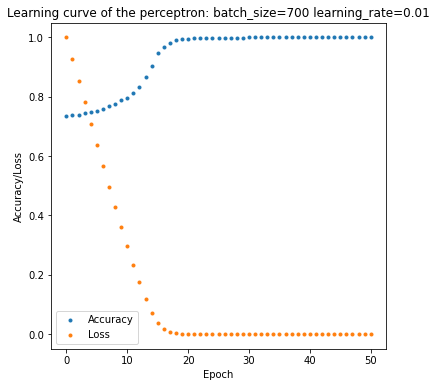

In [15]:
# Build, train and plot the perceptron model for artificial dataset
# Instantiate a perceptron object
art_perceptron = Perceptron()
# Train the perceptron
art_perceptron.train(X=art_train_X, y=art_train_y, max_iteration=1000, 
        early_stopping_cycle=20, learning_rate=0.01, verbose=0)
# Plot the learning curve
art_perceptron.learning_curve()

In [16]:
# Accuracy of perceptron model in artificial data testing set
accuracy_score(y_pred=art_perceptron.predict(art_test_X), y_true=art_test_y)

1.0

# Diabetes Dataset

execution time: 0.10149407386779785
execution time: 0.45342516899108887
execution time: 0.1784970760345459
execution time: 0.20571494102478027


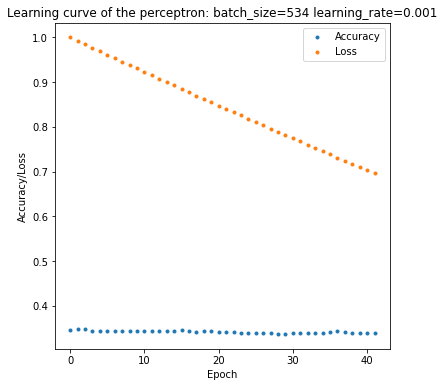

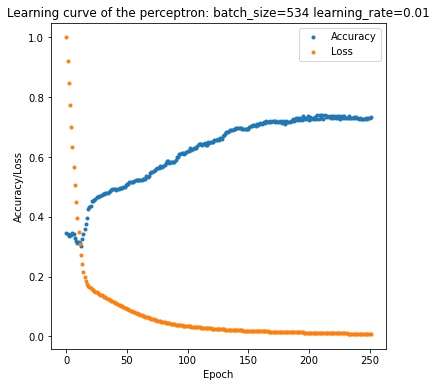

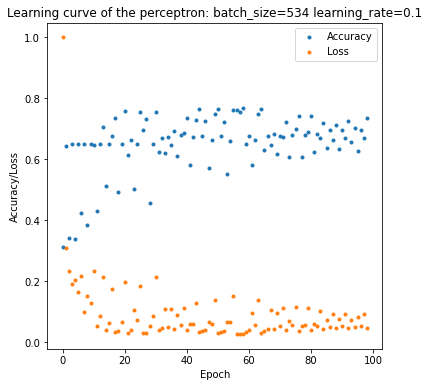

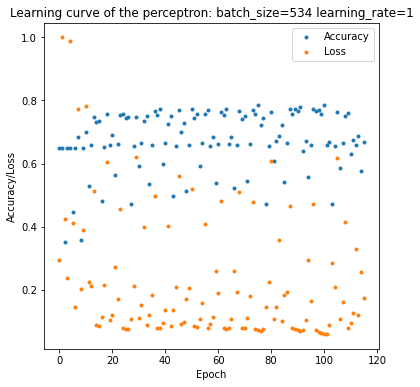

In [17]:
#comprehensive learning rate comparsion 
learning_rate = [1e-3, 1e-2, 1e-1, 1]
for lr in learning_rate:
    # Instantiate a perceptron object
    perceptron = Perceptron()
    # Train the perceptron
    perceptron.train(X=X_train, y=y_train, max_iteration=1000, 
                     early_stopping_cycle=40, learning_rate=lr, verbose=0)
    # Plot the learning curve
    perceptron.learning_curve(save=True)

execution time: 0.13172125816345215
Validation accuracy: 0.7966101694915254
execution time: 0.17557477951049805
Validation accuracy: 0.788135593220339
execution time: 0.40203094482421875
Validation accuracy: 0.7457627118644068
execution time: 0.4205288887023926
Validation accuracy: 0.7372881355932204


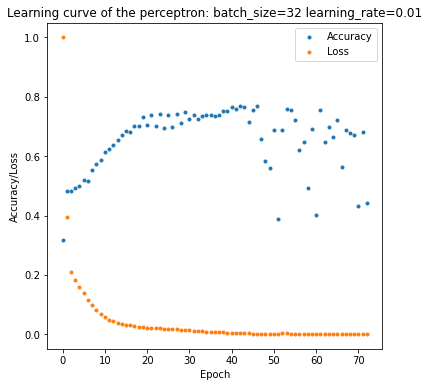

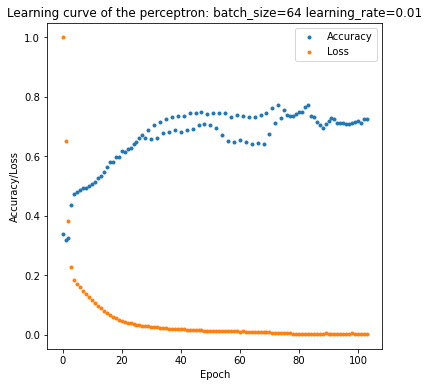

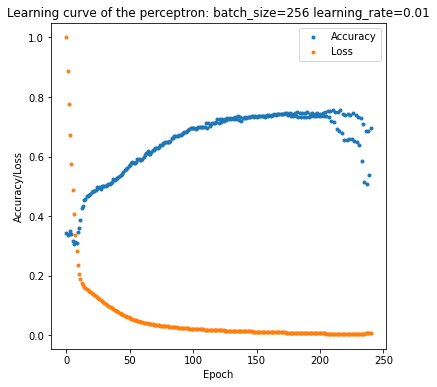

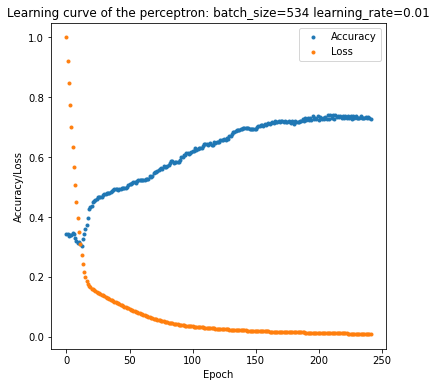

In [18]:
# Comprehensive batch size comparsion
batch_sizes = [32, 64, 256, None]
for batch_size in batch_sizes:
    # Instantiate a perceptron object
    perceptron = Perceptron()
    # Train the perceptron
    perceptron.train(X=X_train, y=y_train, max_iteration=1000, 
            early_stopping_cycle=30, learning_rate=0.01, verbose=0, batch_size=batch_size)
    # Plot the learning curve
    perceptron.learning_curve()
    print(f"Validation accuracy: {accuracy_score(y_pred=perceptron.predict(X_valid), y_true=y_valid)}")

# Final Model Evaluation

In [19]:
# Split the whole training set(including training and validation set)into X(features) and y(label)
X_train_whole = training_set_whole[:,1:]
y_train_whole = training_set_whole[:,0:1]

execution time: 0.4252474308013916
Validation accuracy: 0.7627118644067796


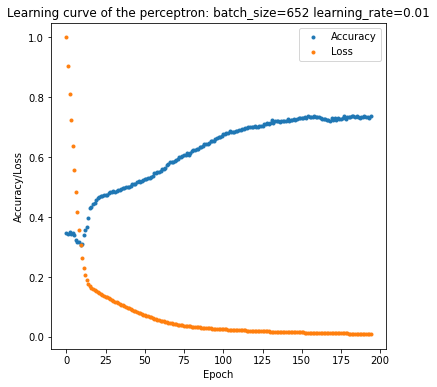

In [20]:
# Instantiate a perceptron object
perceptron = Perceptron()
# Train the perceptron
perceptron.train(X=X_train_whole, y=y_train_whole, max_iteration=1000, 
        early_stopping_cycle=40, learning_rate=1e-2, verbose=0, batch_size=None)
# Plot the learning curve
perceptron.learning_curve()
print(f"Validation accuracy: {accuracy_score(y_pred=perceptron.predict(X_valid), y_true=y_valid)}")

In [21]:
# Accuracy of the test set
accuracy_score(y_pred=perceptron.predict(X_test), y_true=y_test)

0.6982758620689655

In [22]:
# Recall rate of test set
recall_score(y_pred=perceptron.predict(X_test), y_true=y_test)

0.8552631578947368

In [23]:
# Weight of the perceptron(Feature Importance)
perceptron._best_weight.round(2)

array([ 20.32,  -6.5 , -18.43,   1.53,  -0.4 ,   8.87, -13.79,   9.03,
         7.61])

In [24]:
# Calculate the accuracy of predicting -1 and 1
y_pred = perceptron.predict(X_test)
acc_m1 = 0
acc_1 = 0
for i in range(len(y_pred)):
    if y_pred[i] == -1 and y_test.ravel()[i] == -1:
        acc_m1 += 1
    if y_pred[i] == 1 and y_test.ravel()[i] == 1:
        acc_1 += 1
print(f"Accuracy of 1: {acc_1/y_test.ravel().tolist().count(1)}")
print(f"Accuracy of -1: {acc_m1/y_test.ravel().tolist().count(-1)}")

Accuracy of 1: 0.8552631578947368
Accuracy of -1: 0.4


<BarContainer object of 2 artists>

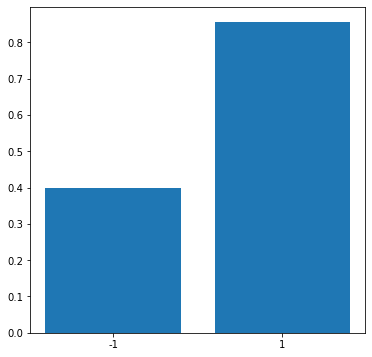

In [25]:
# Plot the distribution of accuracy of -1 and 1
fig, ax = plt.subplots(1,1, figsize=[6,6])
plt.bar(["-1","1"], [acc_m1/y_test.ravel().tolist().count(-1), acc_1/y_test.ravel().tolist().count(1)])
#fig.savefig("/Users/fuchuenli/Desktop/Year 1/Trimester 3/COMP SCI 7318/Week 2/Assignment 1/accuracy_comparsion.png")